In [1]:
from qiskit_aer import AerSimulator
from qiskit import *
import supermarq
from qiskit.providers.fake_provider import *
import numpy as np 
import os
import random
########## INPUT ############
f=5 # number of fake_backend want to choose
lower_limit= 4 # the lower limit of qubits for the circuit
upper_limit=  11# the lower limit of qubits for the circuit
steps= 2 #jump in qubit numbers
name_of_algo='bitcode'

In [2]:
#all_fakes=[FakeAlmadenV2,FakeArmonkV2,FakeAthensV2,FakeAuckland,FakeBelemV2,FakeBoeblingenV2,FakeBogotaV2,FakeBrooklynV2,FakeBurlingtonV2,FakeCairoV2,FakeCambridgeV2,FakeCasablancaV2,FakeEssexV2,FakeGeneva,FakeGuadalupeV2,FakeHanoiV2,FakeJakartaV2,FakeJohannesburgV2,FakeKolkataV2,FakeLagosV2,FakeLimaV2,FakeLondonV2,FakeManhattanV2,FakeManilaV2,FakeMelbourneV2,FakeMontrealV2,FakeMumbaiV2,FakeNairobiV2,FakeOslo,FakeOurenseV2,FakeParisV2,FakePerth,FakePrague,FakePoughkeepsieV2,FakeQuitoV2,FakeRochesterV2,FakeRomeV2,FakeSantiagoV2,FakeSherbrooke,FakeSingaporeV2,FakeSydneyV2,FakeTorontoV2,FakeValenciaV2,FakeVigoV2,FakeWashingtonV2,FakeYorktownV2]
#selected_fakes = random.sample(all_fakes, f)
#selected_fakes  # having any randomly selected 5 fake backends out of 46 mentioned in the inital list
selected_fakes=[FakeBoeblingenV2,FakeRomeV2,FakeGeneva,FakeTorontoV2,FakeRochesterV2]

In [3]:
benchmarks=[]
for i in range(lower_limit,upper_limit,steps):
    label = name_of_algo+str(i)
    rand_list=[]
    for j in range(i):       
        rand_list.append(random.randint(0,1))
    #print("i=",i,"i-1=",i-1,"rand_list=",rand_list)
    benchmarks.append((supermarq.bit_code.BitCode(i,i-1,rand_list),label))
for i in benchmarks:
    circuit=i[0].qiskit_circuit()
    print("--------------------------",i[1],"---------------------------")
    #circuit.draw(output="mpl")
    #print(circuit.draw())

-------------------------- bitcode3 ---------------------------
-------------------------- bitcode6 ---------------------------
-------------------------- bitcode9 ---------------------------


In [4]:
benchmark_features = {}
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.converters.compute_communication_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_depth_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_entanglement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_liveness_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_measurement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_parallelism_with_qiskit(benchmark.qiskit_circuit()),]
print(benchmark_features)

{'bitcode3': [0.4, 0.5, 0.8, 0.62, 0.4444444444444444, 0.0], 'bitcode6': [0.18181818181818182, 0.2, 0.9615384615384616, 0.6735537190082644, 0.2857142857142857, 0.13636363636363638], 'bitcode9': [0.11764705882352941, 0.125, 0.9696969696969697, 0.7006920415224913, 0.48484848484848486, 0.1801470588235294]}


In [5]:
import time
import pandas as pd
from IPython.display import display
jobs =[]
data=[]
print("=============SCORES OF ALL THE CIRCUITS=============")    
for backend in selected_fakes:
    print("BACKEND-NAME :: ", backend().name)
    for benchmark, label in benchmarks:
        circuit=benchmark.qiskit_circuit()
        score_list=[]
        timetaken=[]
        for i in range(0,3):
            start=time.time()
            job = backend().run(circuit, shots=1000)
            result = job.result()
            counts = job.result(0).get_counts()
            score = benchmark.score(counts)
            end=time.time()-start
            score_list.append(score)
            t=job.result(0).time_taken
            timetaken.append(t)
            #print(label ," ExecutionTime:",t,"& Total time:",end)
            print(i+1,"th iteration ,", label ,", Execution time::",t, ", Total Time Taken ::",end )
        print("------------------------------------------")
        score = np.mean(score_list) 
        sd = np.std(score_list)
        execution_time = np.mean(timetaken)
        dictionary={}
        dictionary["Backend_Time"]=backend().name
        dictionary["Ciruit_Name"]=label    
        dictionary["Execution_Time"]=execution_time
        dictionary["Total_Time"]=end
        data.append(dictionary)
        jobs.append((label,benchmark,backend,job,score,sd,execution_time,end))
#jobs
df = pd.DataFrame(data)
display(df)
df.to_excel(r"./output_bitcode.xlsx", index=False)

=============SCORES OF ALL THE CIRCUITS=============
BACKEND-NAME ::  fake_boeblingen
1 th iteration , bitcode3 , Execution time:: 0.08557629585266113 , Total Time Taken :: 0.38170552253723145
2 th iteration , bitcode3 , Execution time:: 0.15934991836547852 , Total Time Taken :: 0.45468664169311523
3 th iteration , bitcode3 , Execution time:: 0.09950399398803711 , Total Time Taken :: 0.399425745010376
------------------------------------------
1 th iteration , bitcode6 , Execution time:: 0.45091986656188965 , Total Time Taken :: 0.7574930191040039
2 th iteration , bitcode6 , Execution time:: 0.3913583755493164 , Total Time Taken :: 0.6237854957580566
3 th iteration , bitcode6 , Execution time:: 0.6011712551116943 , Total Time Taken :: 0.8353097438812256
------------------------------------------
1 th iteration , bitcode9 , Execution time:: 33.06395196914673 , Total Time Taken :: 33.404944896698
2 th iteration , bitcode9 , Execution time:: 34.08538269996643 , Total Time Taken :: 34.4119

,Backend_Time,Ciruit_Name,Execution_Time,Total_Time
0,fake_boeblingen,bitcode3,0.114810,0.399426
1,fake_boeblingen,bitcode6,0.481150,0.835310
2,fake_boeblingen,bitcode9,33.577863,33.902390
3,fake_rome,bitcode3,0.024815,0.083499
4,fake_rome,bitcode6,0.297598,0.329246
5,fake_rome,bitcode9,22.731551,23.063925
6,fake_geneva,bitcode3,0.248916,0.834359
7,fake_geneva,bitcode6,0.395410,1.084388
8,fake_geneva,bitcode9,23.341782,24.130453
9,fake_toronto,bitcode3,0.023875,0.229589


In [7]:
all_scores={}  
all_fake_names=[]
all_fake_scores=[]
for i in selected_fakes:
    fakes=i
    i={}
    for label,benchmark,backend,job,score,sd,exec,tot in jobs:
        #supermarq.plotting.plot_results([score], [label])
        if fakes == backend:
            i[label] = score
    device_scores = 'device_score_' +str(fakes().name)
    all_scores[device_scores]= i
    all_fake_scores.append(i)
    all_fake_names.append(device_scores)   

In [11]:
for label,benchmark,backend,job,score,sd,exec,tot in jobs:
    print("USED BACKEND::",backend().name,"; CIRCUIT_NAME:",label, "; SCORE =",score)
    #supermarq.plotting.plot_results([score], [label])
    print("-----------------------------------------------------------")

USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: bitcode3 ; SCORE = 0.0
-----------------------------------------------------------
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: bitcode6 ; SCORE = 0.0
-----------------------------------------------------------
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: bitcode9 ; SCORE = 1.9721522630525295e-31
-----------------------------------------------------------
USED BACKEND:: fake_rome ; CIRCUIT_NAME: bitcode3 ; SCORE = 0.0
-----------------------------------------------------------
USED BACKEND:: fake_rome ; CIRCUIT_NAME: bitcode6 ; SCORE = 0.0
-----------------------------------------------------------
USED BACKEND:: fake_rome ; CIRCUIT_NAME: bitcode9 ; SCORE = 0.0
-----------------------------------------------------------
USED BACKEND:: fake_geneva ; CIRCUIT_NAME: bitcode3 ; SCORE = 0.0
-----------------------------------------------------------
USED BACKEND:: fake_geneva ; CIRCUIT_NAME: bitcode6 ; SCORE = 0.0
---------------------------

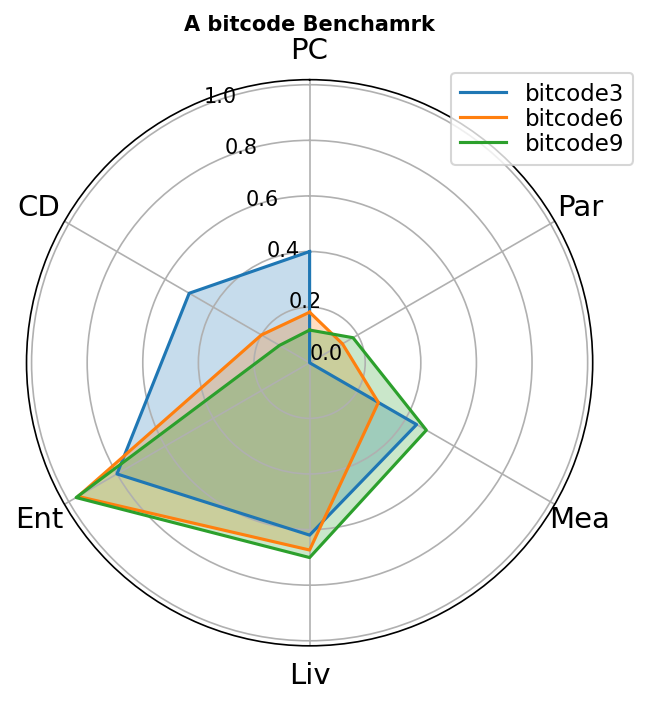

In [12]:
names=[]
scores=[]
X="A "+name_of_algo+' Benchamrk'
for i,j in benchmark_features.items():
    names.append(i)
    scores.append(j)
supermarq.plotting.plot_benchmark(
        [X,names,scores],
        spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],
        show=True)

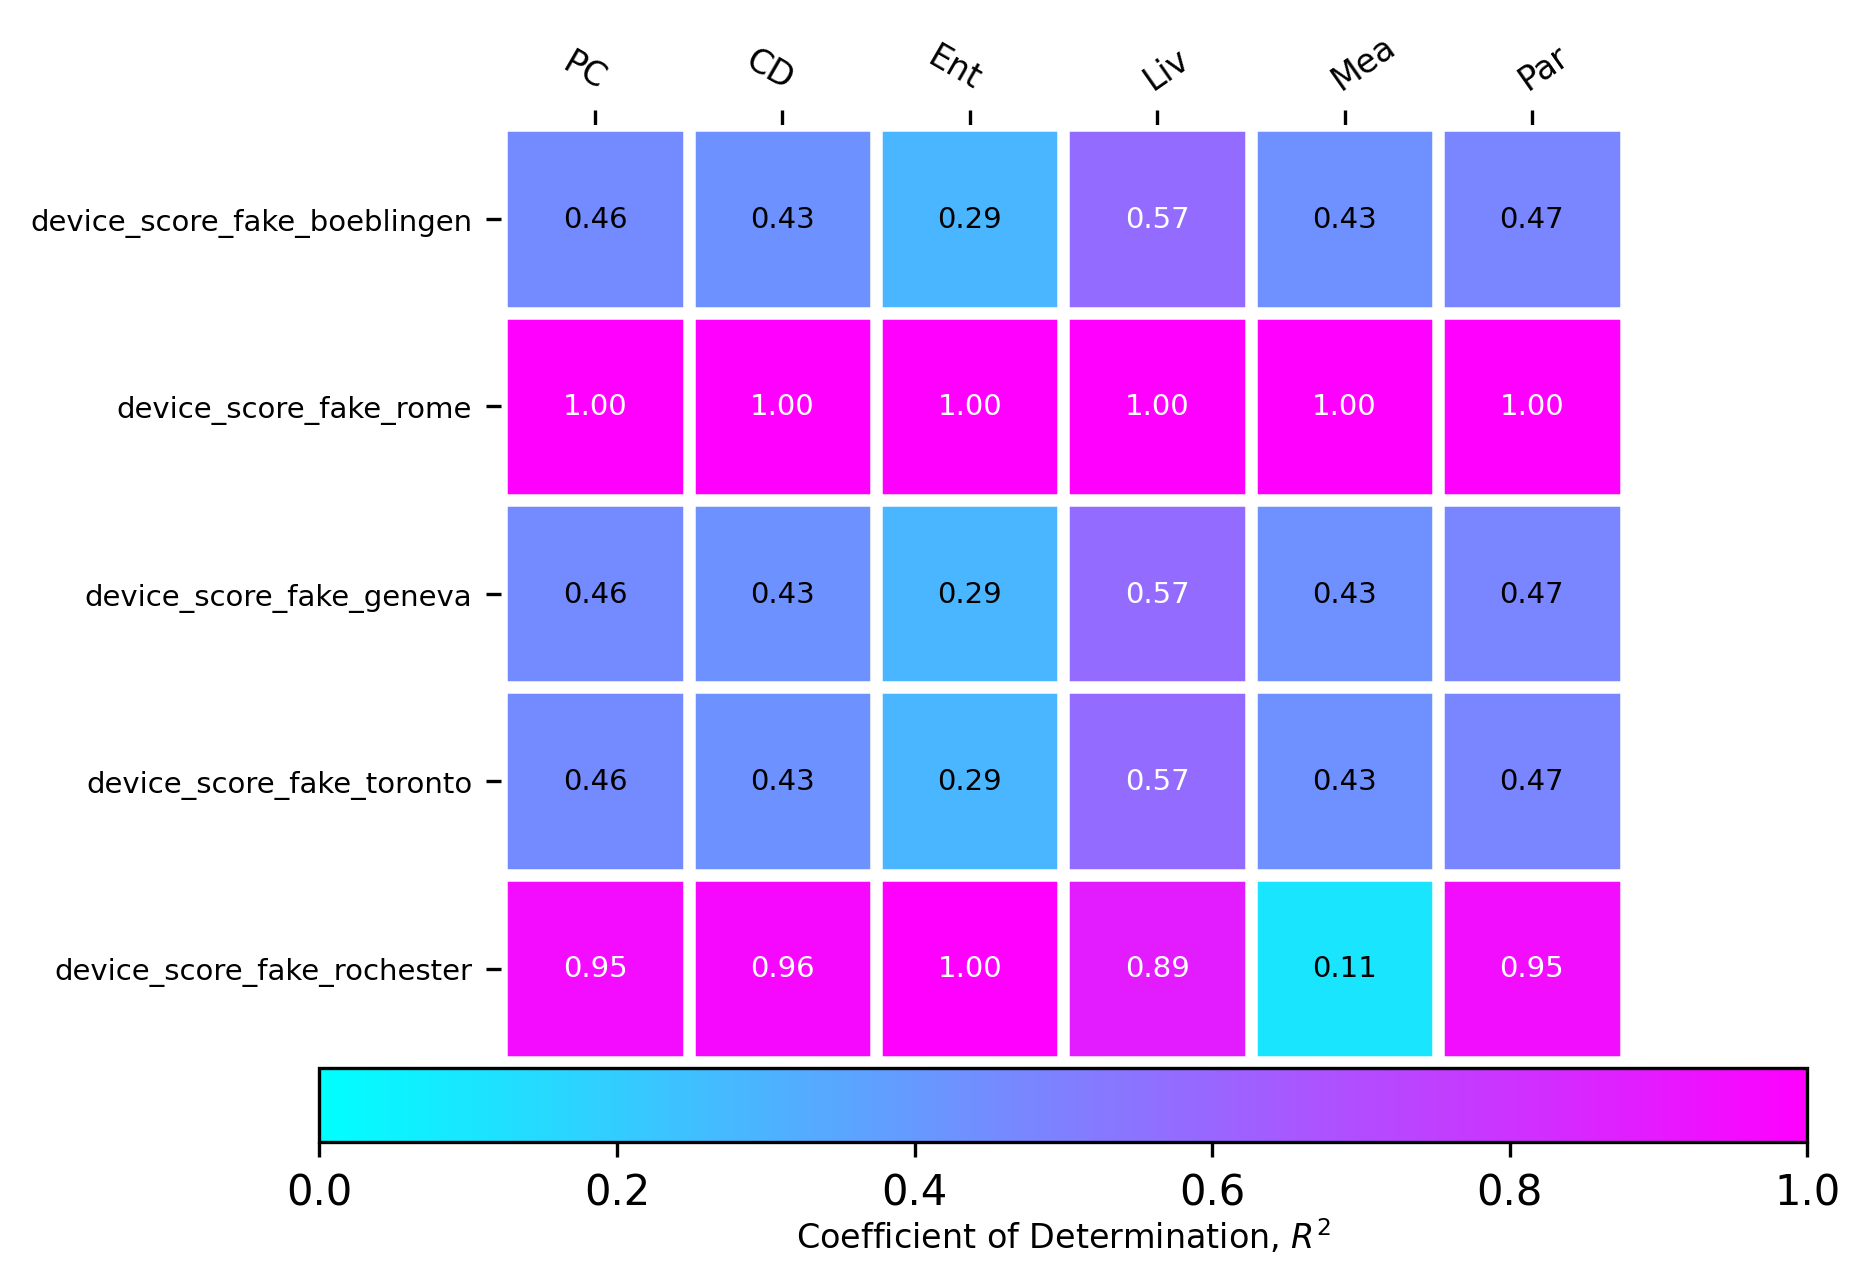

In [13]:
supermarq.plotting.plot_correlations(benchmark_features,all_fake_scores,["PC", "CD", "Ent", "Liv", "Mea", "Par"],device_name=all_fake_names,show=True,)

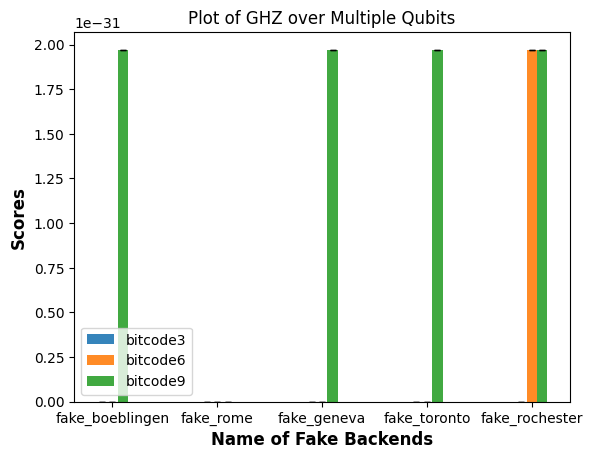

In [16]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np
all_fake_names=[]
all_score=[]
all_sd=[]
all_ckt=[]
for i in selected_fakes:
    all_fake_names.append(i().name)    
for benchmark, label in benchmarks:
    i=[]
    j=[]
    k=[]
    for ckt,benchmark,backend,job,score,sd,exec,tot in jobs:
        if ckt == label:
            i.append(score)
            j.append(sd)
    all_ckt.append(label)
    all_score.append(i)
    all_sd.append(j)
num_bars = len(all_score)
width = 0.1
x = np.arange(len(all_fake_names)) # x-axis positions for each bar
fig, ax = plt.subplots()
for i in range(num_bars):               # Create bars for each category with appropriate offsets
    ax.bar(x + i * width, all_score[i], width=width, label=f'Bar {i+1}', 
           yerr=all_sd[i],align='center',alpha=0.9,ecolor='black',capsize=2)
ax.set_xlabel('Name of Fake Backends',fontweight ='bold',fontsize = 12)
ax.set_ylabel('Scores',fontweight ='bold',fontsize = 12)
ax.set_title('Plot of GHZ over Multiple Qubits')
ax.set_xticks(x + (num_bars - 1) * width / 2)
ax.set_xticklabels(all_fake_names)
ax.legend(all_ckt,loc="lower left")
#ax.grid(True)
plt.show()

In [17]:
import resource
def get_memory():
    usage = resource.getrusage(resource.RUSAGE_SELF)
    max_mem = usage.ru_maxrss/1024 #in MB
    return max_mem
get_memory()

1175.16796875